<a href="https://colab.research.google.com/github/saktiworkstation/road-to-ai-developer/blob/main/Belajar_Digital_Twin_dan_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Studi Kasus:

Anda bekerja sebagai data scientist di sebuah perusahaan manufaktur yang ingin menerapkan teknologi Digital Twin untuk meningkatkan efisiensi dan keandalan mesin produksi. Tujuan Anda adalah membuat model prediksi untuk mendeteksi kemungkinan kegagalan mesin berdasarkan data sensor yang dikumpulkan secara real-time. Dengan demikian, perusahaan dapat melakukan predictive maintenance untuk mencegah downtime yang tidak terduga.

---

Dataset:

Untuk studi kasus ini, kita akan menggunakan dataset dari Kaggle berjudul "NASA Turbofan Engine Degradation Simulation Data Set".

Link dataset: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

---

Kode Python Lengkap:

Berikut adalah kode Python lengkap untuk menganalisis dan membuat model prediksi kegagalan mesin menggunakan dataset tersebut.

In [13]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [14]:
# Load dataset
# Pastikan Anda telah mengunduh dataset dan menempatkannya di direktori kerja Anda
train_data_path = '/content/train_FD001.txt'
test_data_path = '/content/test_FD001.txt'
rul_data_path = '/content/RUL_FD001.txt'

In [17]:
# Fungsi untuk memuat data
def load_data(data_path):
    df = pd.read_csv(data_path, sep='\s+', header=None)
    # Tidak perlu menghapus kolom [26, 27] karena tidak ada
    column_names = ['unit', 'time_cycles'] + \
                   ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
                   [f'sensor_{i}' for i in range(1, 22)]
    df.columns = column_names
    return df

# Memuat data
train_df = load_data(train_data_path)
test_df = load_data(test_data_path)
rul_df = pd.read_csv(rul_data_path, sep='\s+', header=None)
rul_df.columns = ['RUL']

In [18]:
# Menambahkan kolom RUL pada data training
def add_RUL(df):
    df['RUL'] = df.groupby('unit')['time_cycles'].transform(max) - df['time_cycles']
    return df

train_df = add_RUL(train_df)

# Preprocessing data

In [19]:
# Menghapus sensor yang tidak relevan (nilai konstan)
drop_sensors = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train_df.drop(columns=drop_sensors, inplace=True)
test_df.drop(columns=drop_sensors, inplace=True)

In [20]:
# Normalisasi fitur
scaler = MinMaxScaler()
feature_cols = train_df.columns.difference(['unit', 'time_cycles', 'RUL'])
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

In [21]:
# Menyiapkan data test
test_unit_last_cycle = test_df.groupby('unit').last().reset_index()
test_unit_last_cycle = test_unit_last_cycle.merge(rul_df, left_index=True, right_index=True)
test_X = test_unit_last_cycle[feature_cols]
test_y = test_unit_last_cycle['RUL']

In [22]:
# Menyiapkan data training
X = train_df[feature_cols]
y = train_df['RUL']

In [23]:
# Split data untuk validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Membuat model menggunakan XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [25]:
# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [26]:
# Model terbaik
best_model = grid_search.best_estimator_

In [27]:
# Evaluasi model pada data validasi
y_val_pred = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val = r2_score(y_val, y_val_pred)

print(f'RMSE pada data validasi: {rmse_val}')
print(f'R^2 Score pada data validasi: {r2_val}')

RMSE pada data validasi: 41.35715388215054
R^2 Score pada data validasi: 0.6256312131881714


In [28]:
# Evaluasi model pada data test
y_test_pred = best_model.predict(test_X)
rmse_test = np.sqrt(mean_squared_error(test_y, y_test_pred))
r2_test = r2_score(test_y, y_test_pred)

print(f'RMSE pada data test: {rmse_test}')
print(f'R^2 Score pada data test: {r2_test}')

RMSE pada data test: 32.339295940903604
R^2 Score pada data test: 0.3943779468536377


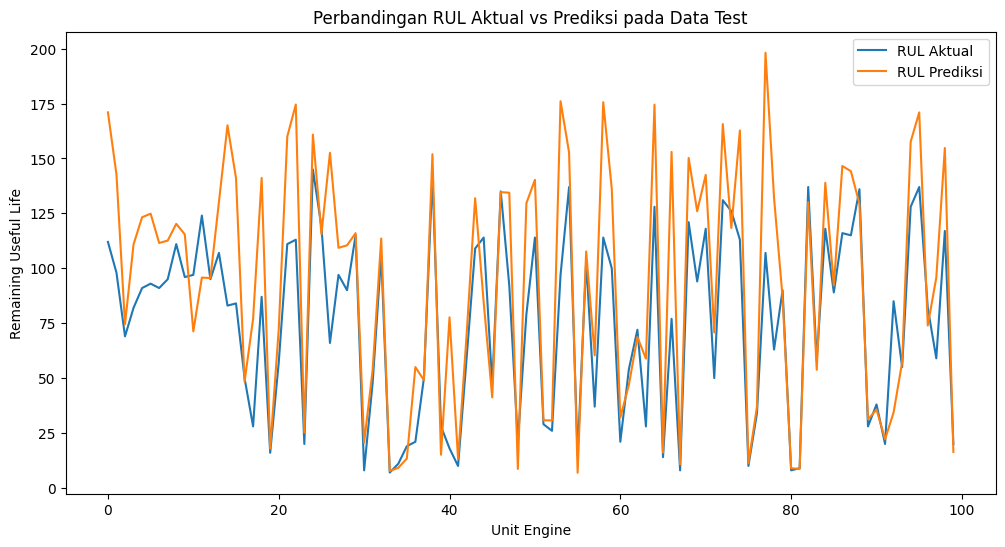

In [29]:
# Visualisasi hasil prediksi pada data test
plt.figure(figsize=(12,6))
plt.plot(test_y.values, label='RUL Aktual')
plt.plot(y_test_pred, label='RUL Prediksi')
plt.xlabel('Unit Engine')
plt.ylabel('Remaining Useful Life')
plt.title('Perbandingan RUL Aktual vs Prediksi pada Data Test')
plt.legend()
plt.show()

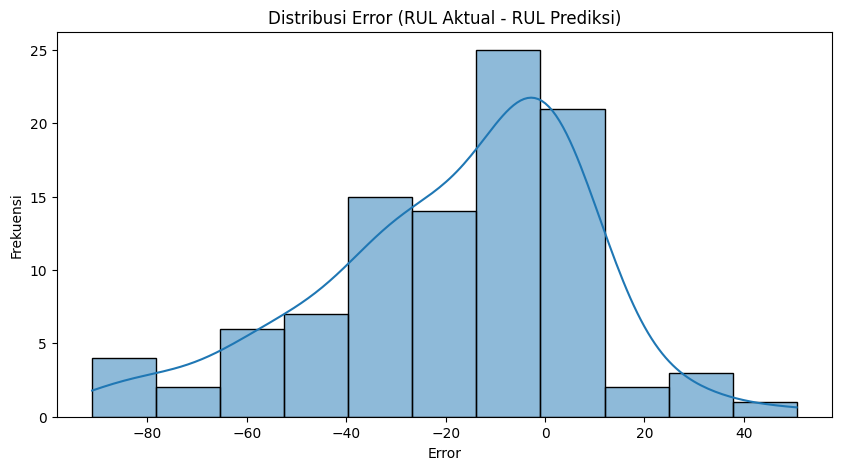

In [30]:
# Visualisasi error distribusi
error = test_y - y_test_pred
plt.figure(figsize=(10,5))
sns.histplot(error, kde=True)
plt.title('Distribusi Error (RUL Aktual - RUL Prediksi)')
plt.xlabel('Error')
plt.ylabel('Frekuensi')
plt.show()

# Penjelasan Kode:

**Import Library:**

Mengimpor semua library yang dibutuhkan seperti pandas, numpy, matplotlib, seaborn, scikit-learn, dan XGBoost.
Load Dataset:

Mendefinisikan fungsi load_data untuk memuat data dan menambahkan nama kolom.
Memuat data training, testing, dan RUL dari file teks yang disediakan.
Menambahkan Kolom RUL pada Data Training:

Menghitung Remaining Useful Life (RUL) dengan mengurangi time_cycles dari siklus maksimum setiap unit.
Preprocessing Data:

Menghapus sensor yang tidak memberikan informasi (nilai konstan).
Normalisasi fitur menggunakan MinMaxScaler agar semua fitur berada dalam skala yang sama.
Menyiapkan Data Testing:

Mengambil data terakhir dari setiap unit dalam data test.
Menggabungkan dengan nilai RUL aktual dari rul_df.
Menyiapkan Data Training dan Validasi:

Memisahkan data menjadi fitur (X) dan target (y).
Membagi data training menjadi training set dan validation set untuk evaluasi model.
Membuat dan Melatih Model:

Menggunakan XGBRegressor dari XGBoost untuk membuat model prediksi.
Melakukan hyperparameter tuning dengan GridSearchCV untuk menemukan kombinasi parameter terbaik.
Evaluasi Model:

Mengukur performa model pada data validasi dan test menggunakan metrik RMSE dan R^2 Score.
Menampilkan hasil evaluasi.
Visualisasi Hasil:

Membuat plot untuk membandingkan RUL aktual dan prediksi pada data test.
Visualisasi distribusi error untuk memahami sebaran kesalahan prediksi.
Catatan Penting:

---

**Persiapan Data:**

Pastikan Anda telah mengunduh dataset dari Kaggle dan menempatkannya dalam direktori kerja yang sesuai dengan train_data_path, test_data_path, dan rul_data_path.
Dataset dapat terdiri dari beberapa subset (FD001 hingga FD004). Kode di atas menggunakan subset FD001. Anda dapat menyesuaikan path dan kode jika menggunakan subset lain.
Hyperparameter Tuning:

Proses GridSearchCV dapat memakan waktu lama tergantung pada ukuran data dan jumlah kombinasi parameter. Anda dapat menyesuaikan param_grid untuk mempercepat proses.
Pengembangan Lebih Lanjut:

Anda dapat mencoba algoritma lain seperti LSTM untuk menangani data time series.
Menambahkan fitur baru atau melakukan feature engineering untuk meningkatkan performa model.
Implementasi teknik pengurangan dimensi seperti PCA jika diperlukan.

---

**Kesimpulan:**

Dengan menerapkan teknologi Digital Twin dan analisis data sensor menggunakan model machine learning, perusahaan dapat memprediksi kegagalan mesin sebelum terjadi. Hal ini memungkinkan pelaksanaan predictive maintenance yang efektif, mengurangi downtime, dan meningkatkan efisiensi operasional.

Semoga kode dan penjelasan ini membantu Anda dalam memahami penerapan Digital Twin menggunakan data CSV dan Python.